In [1]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2
using MCMCDiagnostics

In [2]:
include("../../../util2.j")

colnorm (generic function with 1 method)

In [3]:
# unnecessary packages #

#using Pkg
#Pkg.add("UnicodePlots")
using UnicodePlots   # check the structure of the sparse matrix
using BenchmarkTools

using StatsPlots
using MCMCChains
using PrettyTables

In [4]:
#using Pkg
#Pkg.add("ProgressMeter");

In [5]:
@load "../data/sim2data.jld";

In [6]:
# priors #
K = 2;
μβ = fill(0.0, p, q); 
μΛ = fill(0.0, K, q); 
νΣ = q + 1; ΨΣ = [[1.0 0.0]; [0.0 1.0]];
inv_Lr = [[0.0 0.0]; [0.0 0.0]]; Lμβ = inv_Lr * μβ;
inv_LΛ = [[0.2 0.0]; [0.0 0.2]]; LμΛ = inv_LΛ * μΛ;
#aϕ = [2.0, 2.0]; bϕ = [5.0/2.0, 20.0/2.0]; # 6.0 18.0
ϕU = 300 / sqrt(2); ϕL = 3 / sqrt(2);

In [7]:
# Some data preparations #
M1_ind = setdiff(S, S1_ind);                                  # in S not in S1
M2_ind = setdiff(S, S2_ind);                                  # in S not in S2 
obs_ind = vcat(S1_ind, S2_ind .+ N);              # index of the observed location for all response among N locations
perm_ind = sortperm(vcat(S1_ind, S2_ind));                    # the vector of the permutation 

v1 = zeros(N); v1[S1_ind] .= 1;
v2 = zeros(N); v2[S2_ind] .= 1;
index_S = (2^0 * v1 + 2^1 * v2);                              # build index indicating which response are observed
M1_Sind = findall(x -> x == 2^1, index_S[S]);                 # index of M1 among S
M2_Sind = findall(x -> x == 2^0, index_S[S]);                 # index of M2 among S

m = 10; n = length(S);                                        # number of nearest neighbor                       
NN = BuildNN(coords_ord[S, :], m);                            # build nearest neighbor 
nnIndx_col = vcat(NN.nnIndx, 1:n);                            # the index of columns
nnIndx_row = zeros(Int64, 0);                                               
for i in 2:m
    nnIndx_row = vcat(nnIndx_row, fill(i, i-1))
end
nnIndx_row = vcat(nnIndx_row, repeat((m + 1):n, inner = m), 1:n);  # the index of rows

dim_invD = length(S1_ind) + length(S2_ind);
v12 = convert.(Int, v1 + v2);
v12_s = [x for x in v12 if x > 0];
nrep_ind = [x for i in v12 if i > 0 for x in repeat([i], i)];
invD_yind = [x for i in 1:length(nrep_ind) for x in repeat([perm_ind[i]], nrep_ind[i])];
invD_xind = Array{Float64}(undef, length(invD_yind));
indx_val = 1;
indx_pos = 1;
for i in 1:n
    indx = repeat(perm_ind[indx_val:(indx_val + v12_s[i] - 1)], v12_s[i]);
    invD_xind[indx_pos:(indx_pos + v12_s[i]^2 - 1)] = indx;
    indx_val = indx_val + v12_s[i];
    indx_pos = indx_pos + v12_s[i]^2;
end
Xtilde_indy_up = vcat(S, S .+ N);

In [8]:
# preallocation #

F = Array{Float64,2}(undef, n , K);                           # preallocate the matrix F, store the F before burn-in 
μ_m1 = Array{Float64, 2}(undef, length(M1_ind), q);
μ_m2 = Array{Float64, 2}(undef, length(M2_ind), q);
nIndx = length(NN.nnIndx);
A = [Array{Float64}(undef, nIndx) for i in 1:K];
D = [Array{Float64}(undef, n) for i in 1:K];
I_A = [spzeros(n, n) for i in 1:K];
A_new = [Array{Float64}(undef, nIndx) for i in 1:K];
D_new = [Array{Float64}(undef, n) for i in 1:K];
I_A_new = [spzeros(n, n) for i in 1:K];
Ystar = vcat(Y_ord[S, :], Lμβ, LμΛ);             # will be updated after imputing missing response
#Xstar = vcat([X_ord[S, :] fill(0.0, n, K)], [inv_Lr fill(0.0, p, K)], 
#    [fill(0.0, K, p) inv_LΛ]);
Xstar = vcat([X_ord[S, :] spzeros(n, K)], [inv_Lr spzeros(p, K)], [spzeros(K, p) inv_LΛ]);
Ψstar = fill(0.0, q, q); νstar = νΣ + n;
μγstar = vcat(μβ, μΛ); Vγstar = fill(0.0, p + K, p + K);
Y_Xm = fill(0.0, n, q); invVγstar = fill(0.0, p + K, p + K);
invD_ele = Array{Float64}(undef, length(invD_xind));
invD = SparseMatrixCSC{Float64,Int64};
nsam = length(perm_ind) + (K * n);
Ytilde =  Array{Float64}(undef, nsam);
Xtilde = SparseMatrixCSC{Float64,Int64};
#precond_D = Array{Float64, 1}(undef, K * n);
lll = fill(1.0, (n, 1));

In [9]:
# prediction preparison
M_ind = setdiff(1:N, S); NM = length(M_ind)

# construct Atilde Dtilde #
using RCall
@rput coords_ord
@rput S
@rput m
R"""
library("RANN")
nn_mod_ho <- nn2(coords_ord[S, ], coords_ord[-S, ], k = m)
"""
@rget nn_mod_ho
Atilde = Array{Float64}(undef, NM * m); Dtilde = Array{Float64}(undef, NM);
MnnIndxLU = collect(1:m:(NM * m + 1));
MnnIndx = vec(nn_mod_ho[:nn_idx]');
Mnndists = vec(nn_mod_ho[:nn_dists]');
lllM = fill(1.0, (NM, 1));

MCMC sampling algorithm
Q1: priors for $\nu_i$ 
Q2: $\phi_i$ may not be consistant, since the order can change 

In [10]:
Sys.free_memory()/(2^20*1024)

26.387744903564453

In [11]:
using DelimitedFiles
writedlm("../results/BSLMC_γ_sam.csv", vcat([[0.0 0.0]; [0.0 0.0]; [0.0 0.0]], 
        [[0.0 0.0]; [0.0 0.0]]), ", ")
writedlm("../results/BSLMC_Σ_sam.csv", [[0.0 0.0]; [0.5 0.0]; [0.0 0.5]], ", ")
writedlm("../results/BSLMC_ω_cov_sam.csv", [[0.0 0.0]], ", ")

In [12]:
# Preallocation for MCMC samples and Initalization #
N_sam = 10000;
N_pre_burn = Integer(trunc(0.5 * N_sam));
N_pre_adapt = Integer(trunc(0.25 * N_sam));
N_after_burn = N_sam - N_pre_burn;

ω_incp_sam = Array{Float32, 3}(undef, n, q, N_sam);
F_M_sam = Array{Float32, 2}(undef, NM, K);
ω_incp_M_sam = Array{Float32, 3}(undef, NM, q, N_sam);
Y_M_sam = Array{Float32, 2}(undef, NM, q);

ω_incp_sam_mean = fill(0.0, n, q);
ω_incp_sam_var = fill(0.0, n, q);
Y_m1_sam_mean = fill(0.0, length(M1_ind));
Y_m1_sam_var = fill(0.0, length(M1_ind));
Y_m2_sam_mean = fill(0.0, length(M2_ind));
Y_m2_sam_var = fill(0.0, length(M2_ind));
ω_incp_M_sam_mean = fill(0.0, NM, q);
ω_incp_M_sam_var = fill(0.0, NM, q);
Y_M_sam_mean = fill(0.0, NM, q);
Y_M_sam_var = fill(0.0, NM, q);

A_sam = Array{Float32, 2}(undef, N_sam, K); # acceptance rate
lh_old = 1; lh_new = 1;     # record the likelihood for updating ranges

ϕ_sam = Array{Float64, 2}(undef, K, N_sam + 1);

γ_sam = vcat([[0.0 0.0]; [0.0 0.0]], [[0.0 0.0]; [0.0 0.0]]);
Σ_sam = [[0.5 0.0]; [0.0 0.5]];
ω_cov_sam = [[0.5 0.0]; [0.0 0.5]];
ϕ_sam[:, 1] = [6.0, 18.0];#[6, 30];

RWM_scale = [0.1, 0.1];                                              # random-walk metropolis step size scale 

In [13]:
Sys.free_memory()/(2^20*1024)

26.386554718017578

In [14]:
# for loop for MCMC chain #
Random.seed!(1);
prog = Progress(N_sam, 1, "Computing initial pass...", 50)
for l in 1:N_sam
    # Build the matrix D_Sigma_o^{1/2} #
    Dic_diag = Dict(2^0 => (1 / sqrt(Σ_sam[:, :][1, 1])), 
        2^1 => (1 / sqrt(Σ_sam[:, :][2, 2])), 
        (2^0 + 2^1)=> (sqrt(inv(Σ_sam[:, :]))));
    invD_ele = [x for i in index_S if i > 0 for x in Dic_diag[i]];
    invD = sparse(invD_xind, invD_yind, invD_ele);
                    
    # Build the matrix for the first iteration #
    if l == 1
        for i in 1:K
            getAD(coords_ord[S, :], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ_sam[i], 0.5, A[i], D[i]);
            I_A[i] = sparse(nnIndx_row, nnIndx_col, vcat(-A[i], ones(n)));
        end
    end
                    

    # Build Ytilde Xtilde
    Ytilde = vcat(invD * vcat(Y_ord[S1_ind, 1] - X_ord[S1_ind, :] * γ_sam[1:p, 1], 
                            Y_ord[S2_ind, 2] - X_ord[S2_ind, :] * γ_sam[1:p, 2]), zeros(K * n));
    Xtilde = vcat(invD * kron(sparse(transpose(γ_sam[(p + 1):(p + K), :])), 
                            sparse(1:N, 1:N, ones(N)))[obs_ind, Xtilde_indy_up],
             blockdiag(Diagonal(1 ./ sqrt.(D[1])) * I_A[1], Diagonal(1 ./ sqrt.(D[2])) * I_A[2]));
                
    # use LSMR to generate sample of F #       
    #Precond_D = colnorm(Xtilde);
    #F_sam = reshape(Diagonal(1 ./ Precond_D) * lsmr(Xtilde * Diagonal(1 ./ Precond_D), 
    #        collect(Ytilde) + rand(Normal(), nsam)), :, K);  
    F_sam = reshape(lsmr(Xtilde, collect(Ytilde) + rand(Normal(), nsam)), :, K);
    Xstar[1:n, (p + 1):(p + K)] = F_sam;        # update matrix Xstar with F
                    
    if(l > N_pre_burn) # only save ω_incp_sam after burn-in
        ω_incp_sam[:, :, l] = F_sam * γ_sam[(p + 1):(p + K), :] + lll * transpose(γ_sam[1, :]); 
        ω_incp_sam_mean = ω_incp_sam_mean + (ω_incp_sam[:, :, l] ./ N_after_burn);
        ω_incp_sam_var = ω_incp_sam_var + (ω_incp_sam[:, :, l].^2 ./ N_after_burn);  
        ω_cov_sam = cov(ω_incp_sam[:, :, l]);
    else
        ω_cov_sam = cov(F_sam * γ_sam[(p + 1):(p + K), :]);
    end                    
    io1 = open("../results/BSLMC_ω_cov_sam.csv", "a" ); # covariance of latent process
    writedlm(io1, ω_cov_sam, ", ");
    close(io1);
                    
    # impute missing response  over S#
    mul!(μ_m1, Xstar[M1_Sind, :], γ_sam);
    mul!(μ_m2, Xstar[M2_Sind, :], γ_sam);

    Y_m1_sam = μ_m1[:, 1] + (Σ_sam[1, 2] / Σ_sam[2, 2]) * 
         (Y_ord[M1_ind, 2] - μ_m1[:, 2]) + 
          rand(Normal(0, sqrt(Σ_sam[1, 1] - Σ_sam[1, 2]^2 / Σ_sam[2, 2])), length(M1_ind));
    Y_m2_sam = μ_m2[:, 2] + (Σ_sam[2, 1] / Σ_sam[1, 1]) * 
        (Y_ord[M2_ind, 1] - μ_m2[:, 1]) + 
        rand(Normal(0, sqrt(Σ_sam[2, 2] - Σ_sam[2, 1]^2 / Σ_sam[1, 1])), length(M2_ind)); # improve?...
                    
    if (l > N_pre_burn)  # only save imputed Y after burn-in
        Y_m1_sam_mean = Y_m1_sam_mean + (Y_m1_sam ./ N_after_burn);
        Y_m1_sam_var = Y_m1_sam_var + (Y_m1_sam.^2 ./ N_after_burn);
        Y_m2_sam_mean = Y_m2_sam_mean + (Y_m2_sam ./ N_after_burn);
        Y_m2_sam_var = Y_m2_sam_var + (Y_m2_sam.^2 ./ N_after_burn);
    end
    # use MNIW to sample γ Σ #
    Ystar[M1_Sind, 1] = Y_m1_sam;              # update Ystar with imputed response
    Ystar[M2_Sind, 2] = Y_m2_sam; 
                                       
    invVγstar = cholesky(Xstar'Xstar);
    mul!(μγstar, transpose(Xstar), Ystar); μγstar = invVγstar.U \ (invVγstar.L \ μγstar);
    #Y_Xm = BLAS.gemm('N', 'N', -1.0, Xstar, μγstar) + Ystar;
    Y_Xm = Ystar - Xstar * μγstar;
    mul!(Ψstar, transpose(Y_Xm), Y_Xm); BLAS.axpy!(1.0, ΨΣ, Ψstar);

    Σ_sam = rand(InverseWishart(νstar, Ψstar), 1)[1];    # sample Σ
    γ_sam = (invVγstar.U \ reshape(rand(Normal(), (p + K) * q), (p + K), q)) *
                    cholesky(Σ_sam).U + μγstar;          # sample γ    
    io4 = open("../results/BSLMC_Σ_sam.csv", "a" );
    writedlm(io4, Σ_sam, ", ");
    close(io4); 
    io5= open("../results/BSLMC_γ_sam.csv", "a" );
    writedlm(io5, γ_sam, ", ");
    close(io5)                
                    
    # use metropolis-hasting to update range
    if l > 3 && l < N_pre_adapt
        RWM_scale = [sqrt(2.38^2 * var(ϕ_sam[i, Integer(floor(l / 2)):l], 
                                    corrected=true) * 0.95^2 + 0.05^2 * 0.1^2) 
                            for i in 1:K];
    end
    ϕ_sam[:, l + 1] = [ϕ_sam[i, l] + RWM_scale[i] * rand(Normal(), 1)[1] for i in 1:K]; # propose next sample point
    
    for i in 1:K
        if (ϕ_sam[i, l + 1] > ϕL && ϕ_sam[i, l + 1] < ϕU)
            lh_old = -0.5 * (sum(log.(D[i])) + norm((I_A[i] * F_sam[:, i]) ./ sqrt.(D[i]))^2); 
                            #+ loglikelihood(Gamma(aϕ[i], bϕ[i]), [ϕ_sam[i, l]]);
            getAD(coords_ord[S, :], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ_sam[i, l + 1], 0.5, A_new[i], D_new[i]);
            I_A_new[i] = sparse(nnIndx_row, nnIndx_col, vcat(-A_new[i], ones(n)));
            lh_new = -0.5 * (sum(log.(D_new[i]))  + norm((I_A_new[i] * F_sam[:, i]) ./ sqrt.(D_new[i]))^2);
                            #+ loglikelihood(Gamma(aϕ[i], bϕ[i]), [ϕ_sam[i, l + 1]]);     
            A_sam[l, i] = min(exp(lh_new - lh_old), 1.0);
            if rand(1)[1] < A_sam[l, i]
                I_A[i] = copy(I_A_new[i]); D[i] = copy(D_new[i]);        # update and update the corresponding I_A D
            else 
                ϕ_sam[i, l + 1] = ϕ_sam[i, l];
            end
        else 
            A_sam[l, i] = 0.0;
            ϕ_sam[:, l + 1] = ϕ_sam[:, l];   
        end
    end
                    
    
    # Prediction:
    if(l > N_pre_burn) 
        for j in 1:K
            getAD(coords_ord[S, :], MnnIndx, Mnndists, MnnIndxLU, ϕ_sam[j, l + 1], 0.5, Atilde, Dtilde);
            AtildeM = sparse(repeat(1:NM, inner = m), MnnIndx, Atilde, NM, n);
            F_M_sam[:, j] = AtildeM * F_sam[:, j] + sqrt.(Dtilde) .* rand(Normal(), NM);
        end
        ω_incp_M_sam[:, :, l] = F_M_sam * γ_sam[(p + 1):(p + K), :] + lllM * transpose(γ_sam[1, :]);
        ω_incp_M_sam_mean = ω_incp_M_sam_mean + (ω_incp_M_sam[:, :, l] ./ N_after_burn);
        ω_incp_M_sam_var = ω_incp_M_sam_var + (ω_incp_M_sam[:, :, l].^2 ./ N_after_burn);
        # update Y
        Y_M_sam = X_ord[M_ind, 2:p] * γ_sam[2:p, :] + ω_incp_M_sam[:, :, l] + 
                        transpose(rand(MvNormal(Σ_sam), NM));
        Y_M_sam_mean = Y_M_sam_mean + (Y_M_sam ./ N_after_burn);
        Y_M_sam_var = Y_M_sam_var + (Y_M_sam.^2 ./ N_after_burn);
    end
    next!(prog) # monitor the progress
end
ω_incp_sam_var = ω_incp_sam_var - ω_incp_sam_mean.^2;
Y_m1_sam_var = Y_m1_sam_var - Y_m1_sam_mean.^2;
Y_m2_sam_var = Y_m2_sam_var - Y_m2_sam_mean.^2;
ω_incp_M_sam_var = ω_incp_M_sam_var - ω_incp_M_sam_mean.^2;
Y_M_sam_var = Y_M_sam_var - Y_M_sam_mean.^2;    

Computing initial pass...100%|██████████████████████████████████████████████████| Time: 0:02:19m


In [15]:
round.([mean(A_sam[(N_pre_burn + 1):N_sam, i]) for i in 1:K], digits = 5)

2-element Array{Float32,1}:
 0.15684
 0.22384

In [16]:
RWM_scale

2-element Array{Float64,1}:
 3.0824206331526893
 7.496401417119237 

In [17]:
#load data
using CSV
γ_sam = convert(Matrix{Float64}, CSV.read("../results/BSLMC_γ_sam.csv"));
ind_γ_sam = 1: (p + K) :((p + K) * N_sam + 1);
Σ_sam = convert(Matrix{Float64}, CSV.read("../results/BSLMC_Σ_sam.csv"));
ind_Σ_sam = 1: q :(q * N_sam + 1);
ω_cov_sam = convert(Matrix{Float64}, CSV.read("../results/BSLMC_ω_cov_sam.csv"));
ind_ω_cov_sam = 1: q :(q * (N_sam - 1) + 1);

In [18]:
covω = cov(ω_ord[S, :]);
corω = cor(ω_ord[S, :]);
ω_cov_pos_sam_mean = [mean(ω_cov_sam[ind_ω_cov_sam .+ (i - 1), j][(N_pre_burn + 1):N_sam]) 
    for i in 1:q, j in 1:q];
ω_corr_sam = [(Diagonal([1 / sqrt(ω_cov_sam[ind_ω_cov_sam[l] .+ (i - 1), i]) for i in 1:q]) * 
        ω_cov_sam[ind_ω_cov_sam[l] .+ (1:q) .- 1, 1:q] * 
        Diagonal([1 / sqrt(ω_cov_sam[ind_ω_cov_sam[l] .+ (i - 1), i]) for i in 1:q])) for l in 1:N_sam];
ω_corr_sam_mean = [mean([ω_corr_sam[i][j , k] for i in (N_pre_burn + 1):N_sam]) 
    for j in 1:q, k in 1:q];

Posterior prediction

# MCMC Chain check

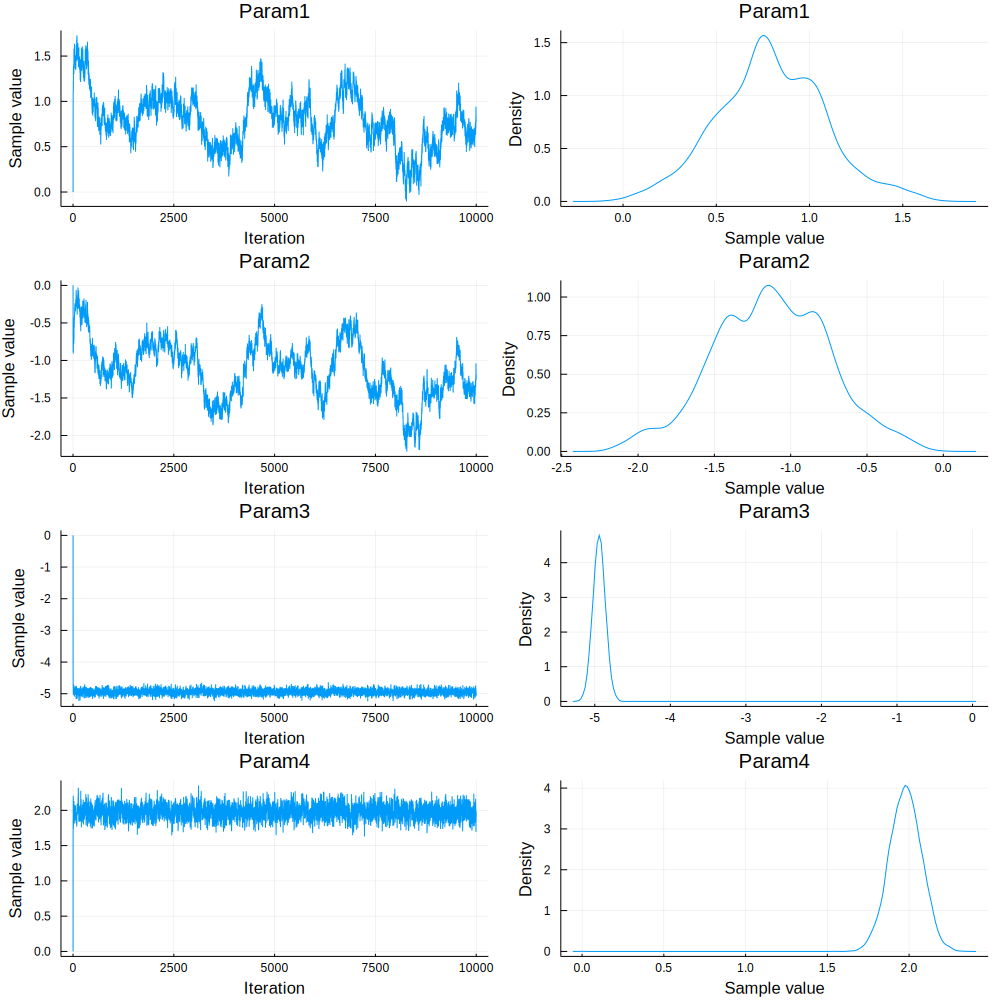

In [19]:
β_pos_sam = Array{Float64, 3}(undef, N_sam + 1, p * q, 1);
β_pos_sam[:, :, 1] = hcat(γ_sam[ind_γ_sam, 1], γ_sam[ind_γ_sam, 2] ,
    γ_sam[ind_γ_sam .+ 1, 1], γ_sam[ind_γ_sam .+ 1, 2]);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

In [20]:
β

2×2 Array{Float64,2}:
  1.0  -1.0
 -5.0   2.0

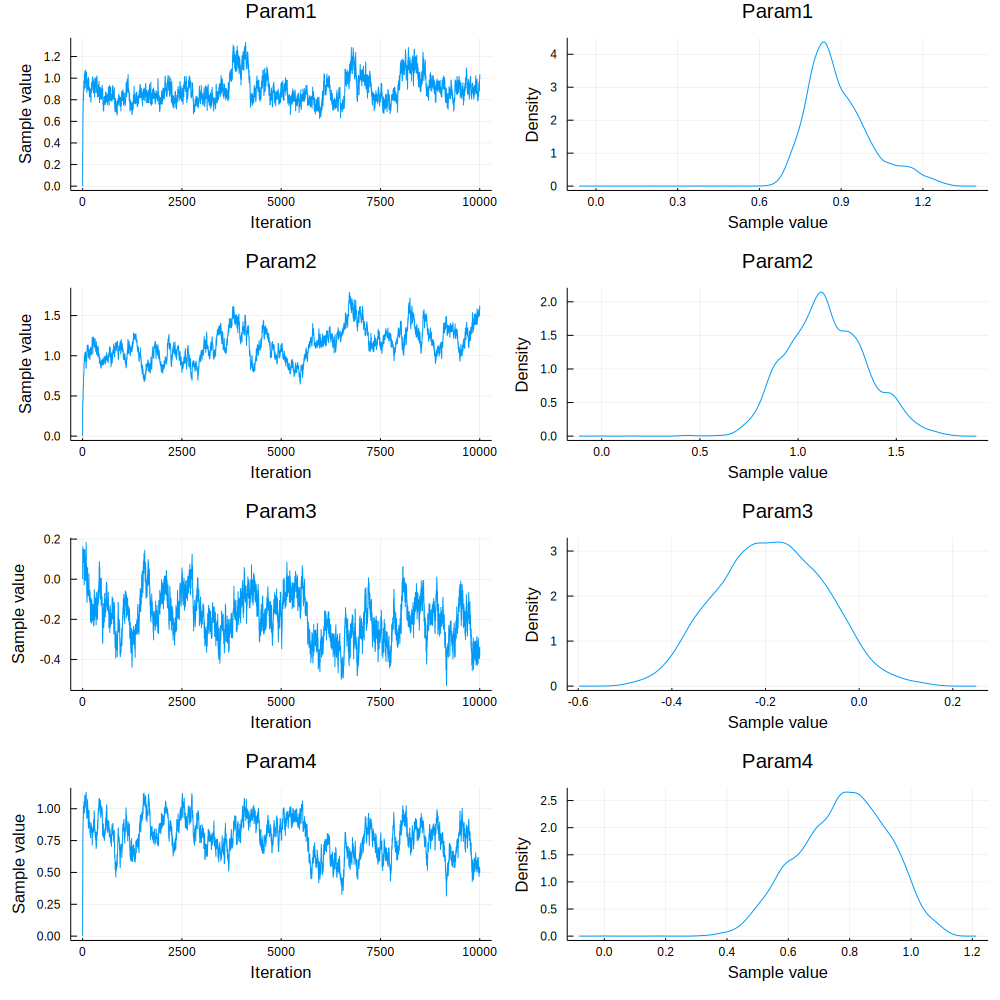

In [21]:
Λ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, K * (q ), 1);
Λ_pos_sam[:, :, 1] = hcat(γ_sam[ind_γ_sam .+ 2, 1], 
    γ_sam[ind_γ_sam .+ 2, 2], 
    γ_sam[ind_γ_sam .+ 3, 1], 
    γ_sam[ind_γ_sam .+ 3, 2]
    );
Λ_chain = Chains(Λ_pos_sam)
pΛ = plot(Λ_chain)

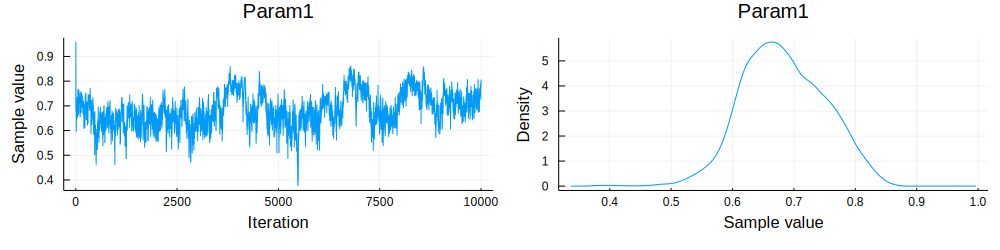

In [22]:
corr_pos_sam = Array{Float64, 3}(undef, N_sam, (q-1) * (q-1), 1);
for i in 1:(N_sam)
    ΛTΛ = γ_sam[(ind_γ_sam[i + 1] + 2):(ind_γ_sam[i + 1] + 3), 
            1:2]'γ_sam[(ind_γ_sam[i + 1] + 2):(ind_γ_sam[i + 1] + 3), 1:2]
    corr_pos_sam[i, 1, 1] = vec(Diagonal(sqrt.( 1 ./ diag(ΛTΛ))) * ΛTΛ * 
        Diagonal(sqrt.( 1 ./ diag(ΛTΛ))))[2];
end
corr_chain = Chains(corr_pos_sam)
pcorr = plot(corr_chain)

In [23]:
mean(corr_pos_sam[:, 1, 1])

0.6832917576032904

In [24]:
cor(ω)

2×2 Array{Float64,2}:
 1.0       0.657497
 0.657497  1.0     

In [25]:
corr = Diagonal([1/sqrt(1.0), 1/sqrt(5.0)]) * (Λ'Λ) * Diagonal([1/sqrt(1.0), 1/sqrt(5.0)])

2×2 Array{Float64,2}:
 1.0       0.447214
 0.447214  0.4     

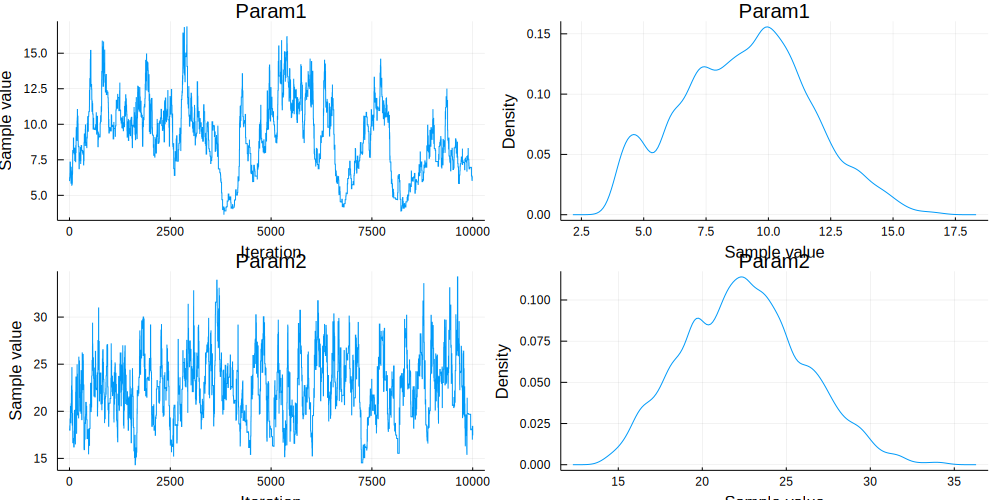

In [26]:
ϕ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, K, 1);
ϕ_pos_sam[:, :, 1] = hcat(ϕ_sam[1, :][1:(N_sam + 1)], ϕ_sam[2, :][1:(N_sam + 1)]);
ϕ_chain = Chains(ϕ_pos_sam);
pϕ = plot(ϕ_chain)

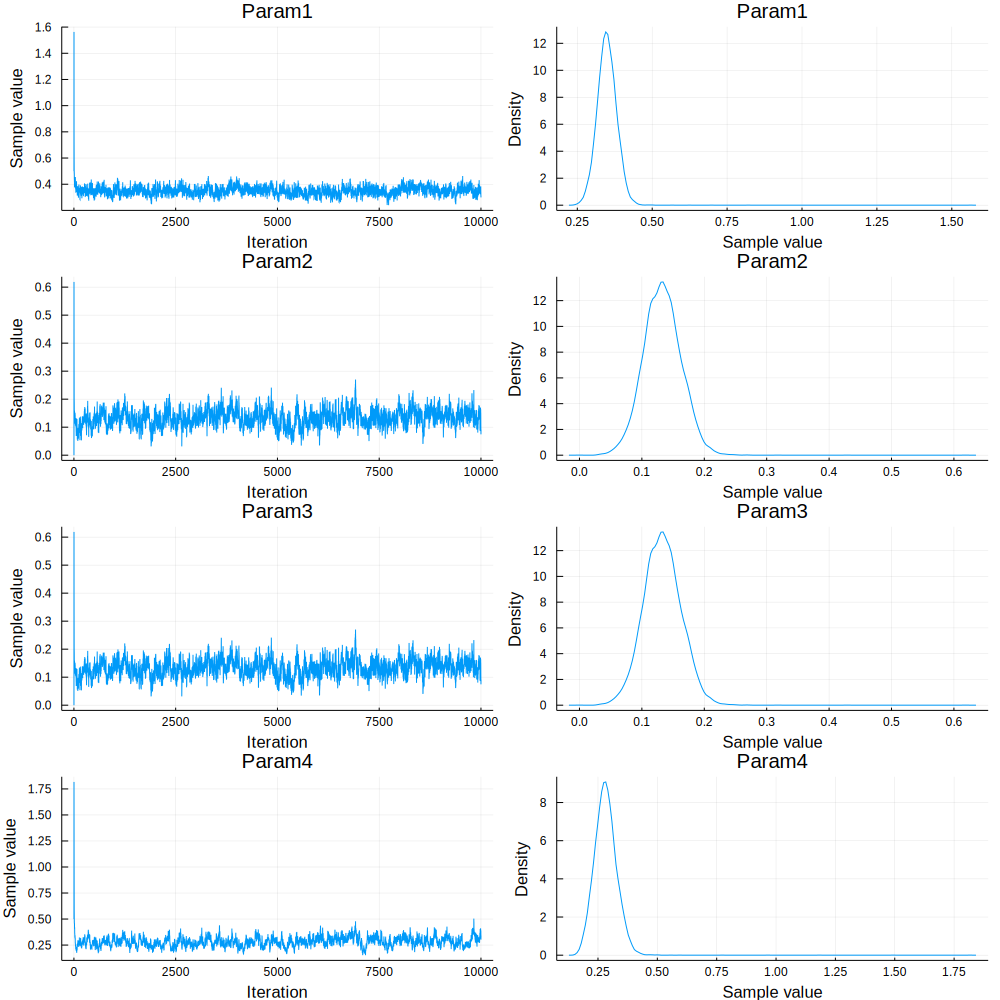

In [27]:
Σ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, q * q, 1);
Σ_pos_sam[:, :, 1] = hcat(Σ_sam[ind_Σ_sam, 1], Σ_sam[ind_Σ_sam, 2], 
    Σ_sam[ind_Σ_sam .+ 1, 1], Σ_sam[ind_Σ_sam .+ 1, 2]);
Σ_chain = Chains(Σ_pos_sam);
pΣ = plot(Σ_chain)

In [28]:
Σ

2×2 Array{Float64,2}:
 0.4   0.15
 0.15  0.3 

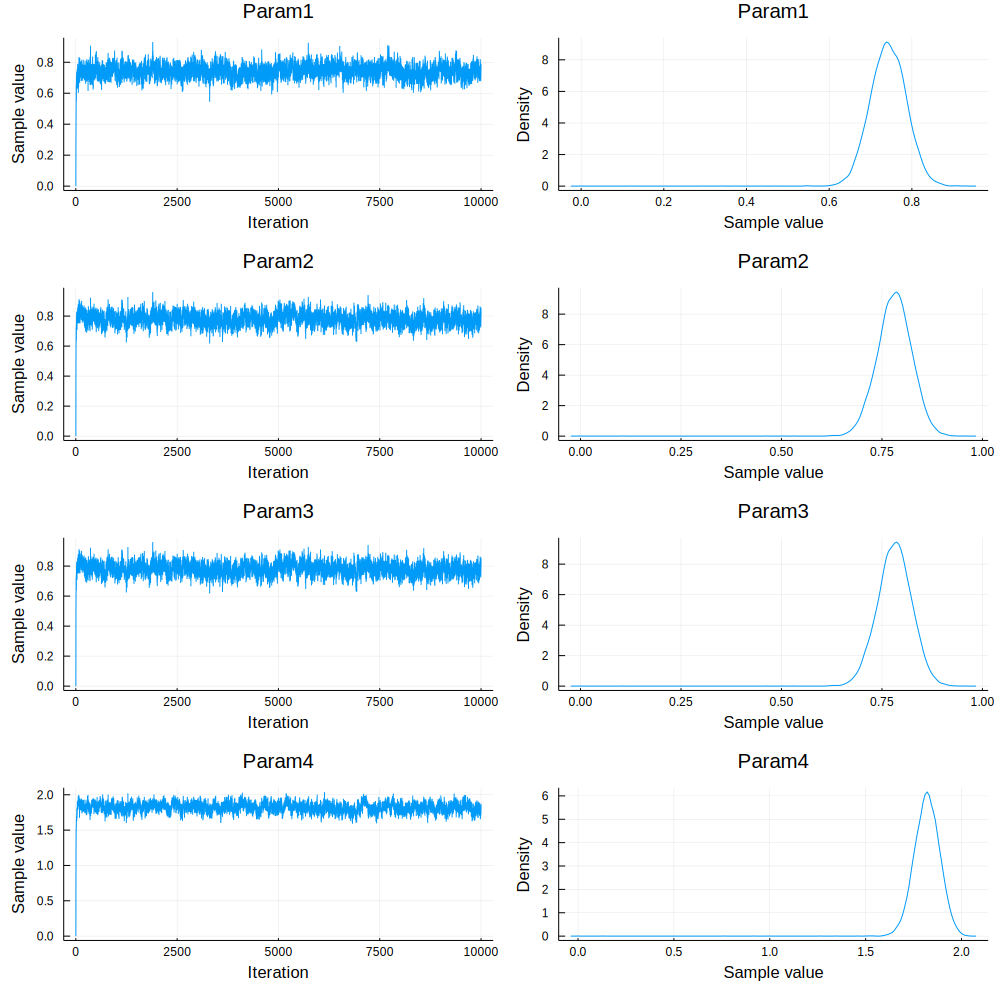

In [29]:
ω_cov_pos_sam = Array{Float64, 3}(undef, N_sam, q * q, 1);
ω_cov_pos_sam[:, :, 1] = hcat(ω_cov_sam[ind_ω_cov_sam, 1], ω_cov_sam[ind_ω_cov_sam, 2], 
    ω_cov_sam[ind_ω_cov_sam .+ 1, 1], ω_cov_sam[ind_ω_cov_sam .+ 1, 2]);
ω_cov_chain = Chains(ω_cov_pos_sam);
pωcov = plot(ω_cov_chain)

In [30]:
covω = cov(ω_ord[S, :])

2×2 Array{Float64,2}:
 0.683048  0.726177
 0.726177  1.78576 

# Posterior Inference 

In [31]:
N_pre_burn = Integer(0.5 * N_sam);
half_sample = Integer((N_sam - N_pre_burn)/2)

2500

In [32]:
using RCall  

In [33]:
# ESS-slope #
ESS_slope = fill(0.0, p, q)
MCSE_slope = fill(0.0, p, q)
Rhat_slope = fill(0.0, p, q)
for i in 1:p
    for j in 1:q
        ESS_slope[i, j] = 
            effective_sample_size(γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + 1):(N_sam + 1)]);
        
        MCMCsample = γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + 1):(N_sam + 1)];
        
        @rput MCMCsample
        R"""
        library(mcmcse)
        mcse1 = mcse(MCMCsample, size = 50)$se
        """
        @rget mcse1
        
        MCSE_slope[i, j] = mcse1;
        #MCSE_slope[i, j] = std(γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + 1):(N_sam + 1)]) / 
        #    sqrt(ESS_slope[i, j]);
        Rhat_slope[i, j] = potential_scale_reduction(
            γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + 1):(N_pre_burn + half_sample)], 
            γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + half_sample + 1):N_sam])
    end
end   
[ESS_slope, MCSE_slope, Rhat_slope]

┌ Warning: RCall.jl: mcmcse: Monte Carlo Standard Errors for MCMC
│ Version 1.4-1 created on 2020-01-29.
│ copyright (c) 2012, James M. Flegal, University of California, Riverside
│                     John Hughes, University of Colorado, Denver
│                     Dootika Vats, University of Warwick
│                     Ning Dai, University of Minnesota
│  For citation information, type citation("mcmcse").
│  Type help("mcmcse-package") to get started.
│ 
└ @ RCall /home/lu/.julia/packages/RCall/g7dhB/src/io.jl:113


3-element Array{Array{Float64,2},1}:
 [9.872017300524076 9.330199582704655; 1794.9432555434364 897.4153301536786]          
 [0.03356293269739106 0.04530670411330008; 0.0019619117012122404 0.003965578983137765]
 [1.320271826644212 1.4050946000717952; 1.0001361583363682 1.0069644305625267]        

In [34]:
# ESS-cov #
ESS_ω_cov = fill(0.0, q, q)
MCSE_ω_cov = fill(0.0, q, q)
Rhat_ω_cov = fill(0.0, q, q)
for j in 1:q
    for i in 1:q
        ESS_ω_cov[i, j] = 
            effective_sample_size(ω_cov_sam[ind_ω_cov_sam .+ (i - 1), j][(N_pre_burn + 1):N_sam]);
        
        MCMCsample = ω_cov_sam[ind_ω_cov_sam .+ (i - 1), j][(N_pre_burn + 1):N_sam]
        
        @rput MCMCsample
        R"""
        library(mcmcse)
        mcse1 = mcse(MCMCsample, size = 50)$se
        """
        @rget mcse1
        
        MCSE_ω_cov[i, j] = mcse1;
        
        #MCSE_ω_cov[i, j] = std(ω_cov_sam[ind_ω_cov_sam .+ (i - 1), j][(N_pre_burn + 1):N_sam]) / 
        #    sqrt(ESS_ω_cov[i, j]);
        Rhat_ω_cov[i, j] = potential_scale_reduction(
            ω_cov_sam[ind_ω_cov_sam .+ (i - 1), j][(N_pre_burn + 1):(N_pre_burn + half_sample)], 
            ω_cov_sam[ind_ω_cov_sam .+ (i - 1), j][(N_pre_burn + half_sample + 1):N_sam]);
    end
end
[ESS_ω_cov, MCSE_ω_cov, Rhat_ω_cov]

3-element Array{Array{Float64,2},1}:
 [115.40482798893278 76.49446114281871; 76.49446114281871 159.21361726437232]             
 [0.0026146927521156233 0.0027541267027121983; 0.0027541267027121983 0.004735008527674705]
 [1.021435161874352 1.016982097562873; 1.016982097562873 1.0011062477710622]              

In [35]:
# ESS-ω #
ESS_ω = fill(0.0, n, q)
MCSE_ω = fill(0.0, n, q)
Rhat_ω = fill(0.0, n, q)
for j in 1:q
    for i in 1:n
        ESS_ω[i, j] = 
            effective_sample_size(ω_incp_sam[i, j, (N_pre_burn + 1):N_sam]);
        
        MCMCsample = ω_incp_sam[i, j, (N_pre_burn + 1):N_sam];
        
        @rput MCMCsample
        R"""
        library(mcmcse)
        mcse1 = mcse(MCMCsample, size = 50)$se
        """
        @rget mcse1
        
        MCSE_ω[i, j] = mcse1;
        
        #MCSE_ω_cov[i, j] = std(ω_cov_sam[ind_ω_cov_sam .+ (i - 1), j][(N_pre_burn + 1):N_sam]) / 
        #    sqrt(ESS_ω_cov[i, j]);
        Rhat_ω[i, j] = potential_scale_reduction(
            ω_incp_sam[i, j, (N_pre_burn + 1):(N_pre_burn + half_sample)], 
            ω_incp_sam[i, j, (N_pre_burn + half_sample + 1):N_sam]);
    end
end
[median(ESS_ω), maximum(MCSE_ω), maximum(Rhat_ω)]

3-element Array{Float64,1}:
 4087.28369140625      
    0.01914245386694582
    1.0080339908599854 

In [36]:
# ESS-ω #
ESS_ω_M = fill(0.0, NM, q)
MCSE_ω_M = fill(0.0, NM, q)
Rhat_ω_M = fill(0.0, NM, q)
for j in 1:q
    for i in 1:NM
        ESS_ω_M[i, j] = 
            effective_sample_size(ω_incp_M_sam[i, j, (N_pre_burn + 1):N_sam]);
        
        MCMCsample = ω_incp_M_sam[i, j, (N_pre_burn + 1):N_sam];
        
        @rput MCMCsample
        R"""
        library(mcmcse)
        mcse1 = mcse(MCMCsample, size = 50)$se
        """
        @rget mcse1
        
        MCSE_ω_M[i, j] = mcse1;
        
        #MCSE_ω_cov[i, j] = std(ω_cov_sam[ind_ω_cov_sam .+ (i - 1), j][(N_pre_burn + 1):N_sam]) / 
        #    sqrt(ESS_ω_cov[i, j]);
        Rhat_ω_M[i, j] = potential_scale_reduction(
            ω_incp_M_sam[i, j, (N_pre_burn + 1):(N_pre_burn + half_sample)], 
            ω_incp_M_sam[i, j, (N_pre_burn + half_sample + 1):N_sam]);
    end
end
[median(ESS_ω_M), maximum(MCSE_ω_M), maximum(Rhat_ω_M)]

3-element Array{Float64,1}:
 4696.81591796875       
    0.016356751967417968
    1.0031182765960693  

In [37]:
# ESS-ϕ #
ESS_ϕ = fill(0.0, K)
MCSE_ϕ = fill(0.0, K)
Rhat_ϕ = fill(0.0, K)
for i in 1:K
    ESS_ϕ[i] = 
        effective_sample_size(ϕ_pos_sam[(N_pre_burn + 1):N_sam, i, 1]);
    
    MCMCsample = ϕ_pos_sam[(N_pre_burn + 1):N_sam, i, 1]
        
    @rput MCMCsample
    R"""
    library(mcmcse)
    mcse1 = mcse(MCMCsample, size = 50)$se
    """
    @rget mcse1
        
    MCSE_ϕ[i] = mcse1;
    
    #MCSE_ϕ[i] = std(ϕ_pos_sam[(N_pre_burn + 1):N_sam, i, 1]) / sqrt(ESS_ϕ[i]);
    
    
    Rhat_ϕ[i] = potential_scale_reduction(
        ϕ_pos_sam[(N_pre_burn + 1):(N_pre_burn + half_sample), i, 1],
        ϕ_pos_sam[(N_pre_burn + half_sample + 1):N_sam, i, 1]);
end
[ESS_ϕ, MCSE_ϕ, Rhat_ϕ]

3-element Array{Array{Float64,1},1}:
 [9.720777911984477, 54.521907083303674]  
 [0.34323201942353687, 0.4156728237989836]
 [1.138532066248193, 1.0050956325112912]  

In [38]:
# ESS-Σ #
ESS_Σ = fill(0.0, q, q)
MCSE_Σ = fill(0.0, q, q)
Rhat_Σ = fill(0.0, q, q)
for i in 1:q
    for j in 1:q
        ESS_Σ[i, j] = 
            effective_sample_size(Σ_sam[ind_Σ_sam .+ (i - 1), j][(N_pre_burn + 1):N_sam]);
        
        
        MCMCsample = Σ_sam[ind_Σ_sam .+ (i - 1), j][(N_pre_burn + 1):N_sam]
        @rput MCMCsample
        R"""
        library(mcmcse)
        mcse1 = mcse(MCMCsample, size = 50)$se
        """
        @rget mcse1
        MCSE_Σ[i, j] = mcse1;
        
        #MCSE_Σ[i, j] = std(Σ_sam[ind_Σ_sam .+ (i - 1), j][(N_pre_burn + 1):N_sam]) / sqrt(ESS_Σ[i, j]);
        Rhat_Σ[i, j] = potential_scale_reduction(
            Σ_sam[ind_Σ_sam .+ (i - 1), j][(N_pre_burn + 1):(N_pre_burn + half_sample)], 
            Σ_sam[ind_Σ_sam .+ (i - 1), j][(N_pre_burn + half_sample + 1):N_sam]);
    end
end
[ESS_Σ, MCSE_Σ, Rhat_Σ]

3-element Array{Array{Float64,2},1}:
 [71.78387868861951 30.13638250854071; 30.13638250854071 70.77927049392177]               
 [0.0023927972261767985 0.0026877444036609854; 0.0026877444036609854 0.004449053661037738]
 [1.0315939428287537 1.0287309712124135; 1.0287309712124135 1.0018903222896445]           

In [39]:
median(vcat(ESS_ω, ESS_ω_M, ESS_Σ, ESS_slope[2:p, :]))

4111.54541015625

In [40]:
maximum(vcat(MCSE_ω, MCSE_ω_M, MCSE_Σ, MCSE_slope[2:p, :]))

0.01914245386694582

In [41]:
summary_table = Array{Float64, 2}(undef, 12, 8);
summary_table[1, :] = vcat(β[1, 1], mean(γ_sam[ind_γ_sam[(N_pre_burn + 1):(N_sam + 1)], 1]),
    quantile(γ_sam[ind_γ_sam[(N_pre_burn + 1):(N_sam + 1)], 1], [0.5, 0.025, 0.975]), 
    ESS_slope[1, 1], MCSE_slope[1, 1], Rhat_slope[1, 1]);
summary_table[2, :] = vcat(β[1, 2], mean(γ_sam[ind_γ_sam[(N_pre_burn + 1):(N_sam + 1)], 2]),
    quantile(γ_sam[ind_γ_sam[(N_pre_burn + 1):(N_sam + 1)], 2], [0.5, 0.025, 0.975]), 
    ESS_slope[1, 2], MCSE_slope[1, 2], Rhat_slope[1, 2]);
summary_table[3, :] = vcat(β[2, 1], mean(γ_sam[ind_γ_sam[(N_pre_burn + 1):(N_sam + 1)] .+ 1, 1]),
    quantile(γ_sam[ind_γ_sam[(N_pre_burn + 1):(N_sam + 1)] .+ 1, 1], [0.5, 0.025, 0.975]), 
    ESS_slope[2, 1], MCSE_slope[2, 1], Rhat_slope[2, 1]);
summary_table[4, :] = vcat(β[2, 2], mean(γ_sam[ind_γ_sam[(N_pre_burn + 1):(N_sam + 1)] .+ 1, 2]),
    quantile(γ_sam[ind_γ_sam[(N_pre_burn + 1):(N_sam + 1)] .+ 1, 2], [0.5, 0.025, 0.975]), 
    ESS_slope[2, 2], MCSE_slope[2, 2], Rhat_slope[2, 2]);
summary_table[5, :] = vcat(Σ[1, 1], mean(Σ_sam[ind_Σ_sam[(N_pre_burn + 1):(N_sam + 1)], 1]),
    quantile(Σ_sam[ind_Σ_sam[(N_pre_burn + 1):(N_sam + 1)], 1], [0.5, 0.025, 0.975]),
    ESS_Σ[1, 1], MCSE_Σ[1, 1], Rhat_Σ[1, 1]);
summary_table[6, :] = vcat(Σ[1, 2], mean(Σ_sam[ind_Σ_sam[(N_pre_burn + 1):(N_sam + 1)], 2]),
    quantile(Σ_sam[ind_Σ_sam[(N_pre_burn + 1):(N_sam + 1)], 2], [0.5, 0.025, 0.975]), 
    ESS_Σ[1, 2], MCSE_Σ[1, 2], Rhat_Σ[1, 2]);
summary_table[7, :] = vcat(Σ[2, 2], mean(Σ_sam[ind_Σ_sam[(N_pre_burn + 1):(N_sam + 1)] .+ 1, 2]),
    quantile(Σ_sam[ind_Σ_sam[(N_pre_burn + 1):(N_sam + 1)] .+ 1, 2], [0.5, 0.025, 0.975]),
    ESS_Σ[2, 2], MCSE_Σ[2, 2], Rhat_Σ[2, 2]);
summary_table[8, :] = vcat(covω[1, 1], mean(ω_cov_sam[ind_ω_cov_sam[(N_pre_burn + 1):N_sam], 1]),
    quantile(ω_cov_sam[ind_ω_cov_sam[(N_pre_burn + 1):N_sam], 1], [0.5, 0.025, 0.975]),
    ESS_ω_cov[1, 1], MCSE_ω_cov[1, 1], Rhat_ω_cov[1, 1]);
summary_table[9, :] = vcat(covω[1, 2], mean(ω_cov_sam[ind_ω_cov_sam[(N_pre_burn + 1):N_sam], 2]),
    quantile(ω_cov_sam[ind_ω_cov_sam[(N_pre_burn + 1):N_sam], 2], [0.5, 0.025, 0.975]),
    ESS_ω_cov[1, 2], MCSE_ω_cov[1, 2], Rhat_ω_cov[1, 2]);
summary_table[10, :] = vcat(covω[2, 2], mean(ω_cov_sam[ind_ω_cov_sam[(N_pre_burn + 1):N_sam] .+ 1, 2]),
    quantile(ω_cov_sam[ind_ω_cov_sam[(N_pre_burn + 1):N_sam] .+ 1, 2], [0.5, 0.025, 0.975]),
    ESS_ω_cov[2, 2], MCSE_ω_cov[2, 2], Rhat_ω_cov[2, 2]);
summary_table[11, :] = vcat(ϕ1, mean(ϕ_sam[1, (N_pre_burn + 1):N_sam]),
    quantile(ϕ_sam[1, (N_pre_burn + 1):N_sam], [0.5, 0.025, 0.975]),
    ESS_ϕ[1], MCSE_ϕ[1], Rhat_ϕ[1]);
summary_table[12, :] = vcat(ϕ2, mean(ϕ_sam[2, (N_pre_burn + 1):N_sam]),
    quantile(ϕ_sam[2, (N_pre_burn + 1):N_sam], [0.5, 0.025, 0.975]),
    ESS_ϕ[2], MCSE_ϕ[2], Rhat_ϕ[2]);
summary_table = round.(summary_table; digits = 3);
rnames = ["β[1, 1]", "β[1, 2]", "β[2, 1]", "β[2, 2]", "Σ[1, 1]", "Σ[1, 2]", "Σ[2, 2]", 
    "cov(ω)[1, 1]", "cov(ω)[1, 2]", "cov(ω)[2, 2]", "ϕ1", "ϕ2"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "true" "mean" "median" "2.5%" "97.5%" "ESS" "MCSE" "Rhat"], markdown)

|              |  true |   mean | median |   2.5% |  97.5% |      ESS |  MCSE  ⋯
|--------------|-------|--------|--------|--------|--------|----------|------- ⋯
|      β[1, 1] |   1.0 |  0.705 |   0.72 |  0.145 |  1.233 |    9.872 | 0.034  ⋯
|      β[1, 2] |  -1.0 |  -1.24 | -1.253 | -1.998 | -0.529 |     9.33 | 0.045  ⋯
|      β[2, 1] |  -5.0 | -4.945 | -4.944 | -5.107 | -4.778 | 1794.943 | 0.002  ⋯
|      β[2, 2] |   2.0 |  1.979 |  1.979 |   1.78 |  2.166 |  897.415 | 0.004  ⋯
|      Σ[1, 1] |   0.4 |  0.346 |  0.346 |  0.283 |  0.409 |   71.784 | 0.002  ⋯
|      Σ[1, 2] |  0.15 |  0.133 |  0.134 |  0.072 |  0.194 |   30.136 | 0.003  ⋯
|      Σ[2, 2] |   0.3 |   0.29 |  0.289 |  0.198 |  0.386 |   70.779 | 0.004  ⋯
| cov(ω)[1, 1] | 0.683 |  0.746 |  0.746 |  0.662 |  0.829 |  115.405 | 0.003  ⋯
| cov(ω)[1, 2] | 0.726 |  0.781 |  0.781 |  0.697 |  0.864 |   76.494 | 0.003  ⋯
| cov(ω)[2, 2] | 1.786 |  1.813 |  1.813 |  1.682 |  1.942 |  159.214 | 0.005  ⋯
|           ϕ1 |   6.0 |  8.

In [42]:
pretty_table(summary_table[:, [1, 2, 7, 8, 9]],  ["" "true" "ESS" "MCSE" "Rhat"], markdown)

|              |  true |      ESS |  MCSE |  Rhat |
|--------------|-------|----------|-------|-------|
|      β[1, 1] |   1.0 |    9.872 | 0.034 |  1.32 |
|      β[1, 2] |  -1.0 |     9.33 | 0.045 | 1.405 |
|      β[2, 1] |  -5.0 | 1794.943 | 0.002 |   1.0 |
|      β[2, 2] |   2.0 |  897.415 | 0.004 | 1.007 |
|      Σ[1, 1] |   0.4 |   71.784 | 0.002 | 1.032 |
|      Σ[1, 2] |  0.15 |   30.136 | 0.003 | 1.029 |
|      Σ[2, 2] |   0.3 |   70.779 | 0.004 | 1.002 |
| cov(ω)[1, 1] | 0.683 |  115.405 | 0.003 | 1.021 |
| cov(ω)[1, 2] | 0.726 |   76.494 | 0.003 | 1.017 |
| cov(ω)[2, 2] | 1.786 |  159.214 | 0.005 | 1.001 |
|           ϕ1 |   6.0 |    9.721 | 0.343 | 1.139 |
|           ϕ2 |  18.0 |   54.522 | 0.416 | 1.005 |


In [43]:
# MAE #
MAE1 = (sum(abs.(Y_ord[M_ind, 1] - Y_M_sam_mean[:, 1])) + sum(abs.(Y_m1_sam_mean - Y_ord[M1_ind, 1]))) / 200
MAE2 = (sum(abs.(Y_ord[M_ind, 2] - Y_M_sam_mean[:, 2])) + sum(abs.(Y_m2_sam_mean - Y_ord[M2_ind, 2]))) / 200
# calculate root mean square predictive error #
MAE = (sum(abs.(Y_ord[M_ind, :] - Y_M_sam_mean)) + sum(abs.(Y_m1_sam_mean - Y_ord[M1_ind, 1]))
           + sum(abs.(Y_m2_sam_mean - Y_ord[M2_ind, 2]))) / (2 * 200)
round.([MAE1 MAE2 MAE], digits = 3)

1×3 Array{Float64,2}:
 0.582  0.592  0.587

In [44]:
# MAEL #
MAEL1 = (sum(abs.(ω_incp_obs[S, 1] - ω_incp_sam_mean[:, 1])) + 
    sum(abs.(ω_incp_obs[M_ind, 1] - ω_incp_M_sam_mean[:, 1]))) / (N);
MAEL2 = (sum(abs.(ω_incp_obs[S, 2] - ω_incp_sam_mean[:, 2])) + 
    sum(abs.(ω_incp_obs[M_ind, 2] - ω_incp_M_sam_mean[:, 2]))) / (N);
MAEL = (sum(abs.(ω_incp_obs[S, :] - ω_incp_sam_mean)) + 
    sum(abs.(ω_incp_obs[M_ind, :] - ω_incp_M_sam_mean))) / (2 * N);
round.([MAEL1 MAEL2 MAEL], digits = 3)

1×3 Array{Float64,2}:
 0.298  0.356  0.327

In [45]:
# RMSPE #
MSPE1 = (sum((Y_ord[M_ind, 1] - Y_M_sam_mean[:, 1]).^2) + sum((Y_m1_sam_mean - Y_ord[M1_ind, 1]).^2)) / 200
RMSPE1 = sqrt(MSPE1); RMSPE1
MSPE2 = (sum((Y_ord[M_ind, 2] - Y_M_sam_mean[:, 2]).^2) + sum((Y_m2_sam_mean - Y_ord[M2_ind, 2]).^2)) / 200
RMSPE2 = sqrt(MSPE2); RMSPE2
# calculate root mean square predictive error #
MSPE = (sum((Y_ord[M_ind, :] - Y_M_sam_mean).^2) + sum((Y_m1_sam_mean - Y_ord[M1_ind, 1]).^2 )
           + sum((Y_m2_sam_mean - Y_ord[M2_ind, 2]).^2)) / (2 * 200)
RMSPE = sqrt(MSPE); 
round.([RMSPE1 RMSPE2 RMSPE], digits = 3)

1×3 Array{Float64,2}:
 0.728  0.756  0.742

In [46]:
# MSPEL #
MSEL1 = (sum((ω_incp_obs[S, 1] - ω_incp_sam_mean[:, 1]).^2) + 
    sum((ω_incp_obs[M_ind, 1] - ω_incp_M_sam_mean[:, 1]).^2)) / (N);
MSEL2 = (sum((ω_incp_obs[S, 2] - ω_incp_sam_mean[:, 2]).^2) + 
    sum((ω_incp_obs[M_ind, 2] - ω_incp_M_sam_mean[:, 2]).^2)) / (N);
MSEL = (sum((ω_incp_obs[S, :] - ω_incp_sam_mean).^2) + 
    sum((ω_incp_obs[M_ind, :] - ω_incp_M_sam_mean).^2)) / (2 * N);
round.([MSEL1 MSEL2 MSEL], digits = 3)

1×3 Array{Float64,2}:
 0.14  0.204  0.172

In [47]:
# MSPEL only for 1000 obversed location #
SSEL = fill(0.0, 2);
for i in 1:n
    for j in 1:q
        if (j == 1) & (sum(i .== M1_Sind) == 0)
            SSEL[j] = SSEL[j] + (ω_incp_obs[S[i], j] - ω_incp_sam_mean[i, j])^2;
        elseif (j == 2) & (sum(i .== M2_Sind) == 0)
            SSEL[j] = SSEL[j] + (ω_incp_obs[S[i], j] - ω_incp_sam_mean[i, j])^2;
        end
    end
end
print(round.(SSEL ./ N1, digits = 3));
print(round(sum(SSEL) / (2 * N1), digits = 3));

[0.136, 0.168]0.152

In [48]:
# CRPS #
CRPS_m1 = [(sqrt(Y_m1_sam_var[i]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[M1_ind[i], 1] - Y_m1_sam_mean[i]) / sqrt(Y_m1_sam_var[i])) -
        ((Y_ord[M1_ind[i], 1] - Y_m1_sam_mean[i]) / sqrt(Y_m1_sam_var[i])) * 
        (2* cdf(Normal(), (Y_ord[M1_ind[i], 1] - Y_m1_sam_mean[i]) / sqrt(Y_m1_sam_var[i])) - 1 )))
        for i in 1:length(M1_ind)];
CRPS_m2 = [(sqrt(Y_m2_sam_var[i]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[M2_ind[i], 2] - Y_m2_sam_mean[i]) / sqrt(Y_m2_sam_var[i])) -
        ((Y_ord[M2_ind[i], 2] - Y_m2_sam_mean[i]) / sqrt(Y_m2_sam_var[i])) * 
        (2* cdf(Normal(), (Y_ord[M2_ind[i], 2] - Y_m2_sam_mean[i]) / sqrt(Y_m2_sam_var[i])) - 1 )))
        for i in 1:length(M2_ind)];

CRPS_U = [(sqrt(Y_M_sam_var[i, j]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[M_ind[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) -
        ((Y_ord[M_ind[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) * 
        (2* cdf(Normal(), (Y_ord[M_ind[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) - 1)))
        for i in 1:NM, j in 1:q];

CRPS1 = (sum(CRPS_U[:, 1]) + sum(CRPS_m1)) / (length(M1_ind) + NM);
CRPS2 = (sum(CRPS_U[:, 2]) + sum(CRPS_m2)) / (length(M2_ind) + NM);
CRPS = (sum(CRPS_U) + sum(CRPS_m1) + sum(CRPS_m2))/(2 * NM + length(M1_ind) + (length(M2_ind)));
round.([CRPS1 CRPS2 CRPS], digits = 3)

1×3 Array{Float64,2}:
 -0.412  -0.423  -0.418

In [49]:
# CRPSL #
CRPSL_S = [(sqrt(ω_incp_sam_var[i, j]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (ω_incp_obs[S[i], j] - ω_incp_sam_mean[i, j]) / sqrt(ω_incp_sam_var[i, j])) -
        ((ω_incp_obs[S[i], j] - ω_incp_sam_mean[i, j]) / sqrt(ω_incp_sam_var[i, j])) * 
        (2* cdf(Normal(), (ω_incp_obs[S[i], j] - ω_incp_sam_mean[i, j]) / sqrt(ω_incp_sam_var[i, j])) - 1)))
        for i in 1:n, j in 1:q];

CRPSL_U = [(sqrt(ω_incp_M_sam_var[i, j]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (ω_incp_obs[M_ind[i], j] - ω_incp_M_sam_mean[i, j]) / sqrt(ω_incp_M_sam_var[i, j])) -
        ((ω_incp_obs[M_ind[i], j] - ω_incp_M_sam_mean[i, j]) / sqrt(ω_incp_M_sam_var[i, j])) * 
        (2* cdf(Normal(), (ω_incp_obs[M_ind[i], j] - ω_incp_M_sam_mean[i, j]) / sqrt(ω_incp_M_sam_var[i, j])) - 1)))
        for i in 1:NM, j in 1:q];

CRPSL1 = (sum(CRPSL_U[:, 1]) + sum(CRPSL_S[:, 1])) / (n + NM);
CRPSL2 = (sum(CRPSL_U[:, 2]) + sum(CRPSL_S[:, 2])) / (n + NM);
CRPSL = (sum(CRPSL_U) + sum(CRPSL_S))/(2 * NM + 2 * n);
round.([CRPSL1 CRPSL2 CRPSL], digits = 3)

1×3 Array{Float64,2}:
 -0.211  -0.251  -0.231

In [50]:
v1 = zeros(N); v1[S1_ind] .= 1;
v2 = zeros(N); v2[S2_ind] .= 1;
index_S = (2^0 * v1 + 2^1 * v2);                              # build index indicating which response are observed
S1_Sind = findall(x -> x == 2^0, index_S[S]);                 # index of M1 among S
S2_Sind = findall(x -> x == 2^1, index_S[S]);                 # index of M2 among S

In [51]:
# CRPSL over observed locations#
CRPSL_S = [(sqrt(ω_incp_sam_var[i, j]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (ω_incp_obs[S[i], j] - ω_incp_sam_mean[i, j]) / sqrt(ω_incp_sam_var[i, j])) -
        ((ω_incp_obs[S[i], j] - ω_incp_sam_mean[i, j]) / sqrt(ω_incp_sam_var[i, j])) * 
        (2* cdf(Normal(), (ω_incp_obs[S[i], j] - ω_incp_sam_mean[i, j]) / sqrt(ω_incp_sam_var[i, j])) - 1)))
        for i in 1:n, j in 1:q];

CRPSL1 = (sum(CRPSL_S[S1_Sind, 1])) / length(S1_ind);
CRPSL2 = (sum(CRPSL_S[S2_Sind, 2])) / length(S2_ind);
CRPSL = (sum(CRPSL_S[S1_Sind, 1]) + sum(CRPSL_S[S2_Sind, 2]))/
(length(S1_ind) + length(S2_ind));
round.([CRPSL1 CRPSL2 CRPSL], digits = 3)

1×3 Array{Float64,2}:
 -0.035  -0.038  -0.036

In [52]:
# CVG #
N_Inf_burn = 1;
count_Y_M = fill(0.0, 2);
for j in 1:q
    for i in 1:NM
        count_Y_M[j] = count_Y_M[j] + 
        (((Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i, j])) < Y_ord[M_ind[i], j]) && 
            ((Y_M_sam_mean[i, j] + 1.96 * sqrt(Y_M_sam_var[i, j])) > Y_ord[M_ind[i], j]))
    end
end
for i in 1:length(M1_ind)
    count_Y_M[1] = count_Y_M[1] + 
        (((Y_m1_sam_mean[i] - 1.96 * sqrt(Y_m1_sam_var[i])) < Y_ord[M1_ind[i], 1]) && 
         ((Y_m1_sam_mean[i] + 1.96 * sqrt(Y_m1_sam_var[i])) > Y_ord[M1_ind[i], 1]))
end
for i in 1:length(M2_ind)
    count_Y_M[2] = count_Y_M[2] + 
        (((Y_m2_sam_mean[i] - 1.96 * sqrt(Y_m2_sam_var[i])) < Y_ord[M2_ind[i], 2]) && 
         ((Y_m2_sam_mean[i] + 1.96 * sqrt(Y_m2_sam_var[i])) > Y_ord[M2_ind[i], 2]))
end
print(count_Y_M ./ 200);
print(round(sum(count_Y_M) / 400, digits = 3))

[0.915, 0.955]0.935

In [53]:
# CVGL over 1200 locations#
count_ω_incp = fill(0.0, 2);
for j in 1:q
    for i in 1:n
        count_ω_incp[j] = count_ω_incp[j] + 
        (((ω_incp_sam_mean[i, j] - 1.96 * sqrt(ω_incp_sam_var[i, j])) < ω_incp_obs[S[i], j]) && 
        ((ω_incp_sam_mean[i, j] + 1.96 * sqrt(ω_incp_sam_var[i, j])) > ω_incp_obs[S[i], j]))
    end
end
for j in 1:q
    for i in 1:NM
        count_ω_incp[j] = count_ω_incp[j] + 
        (((ω_incp_M_sam_mean[i, j] - 1.96 * sqrt(ω_incp_M_sam_var[i, j])) < ω_incp_obs[M_ind[i], j]) && 
        ((ω_incp_M_sam_mean[i, j] + 1.96 * sqrt(ω_incp_M_sam_var[i, j])) > ω_incp_obs[M_ind[i], j]))
    end
end
print(round.(count_ω_incp ./ N, digits = 3))
print(round(sum(count_ω_incp) / (2*N), digits = 3))

[0.951, 0.961]0.956

In [54]:
# CVGL only for 1000 obversed location #
count_ω_incp = fill(0.0, 2);
for i in 1:n
    for j in 1:q
        if (j == 1) & (sum(i .== M1_Sind) == 0)
            count_ω_incp[j] = count_ω_incp[j] + 
                (((ω_incp_sam_mean[i, j] - 1.96 * sqrt(ω_incp_sam_var[i, j])) < ω_incp_obs[S[i], j]) && 
                ((ω_incp_sam_mean[i, j] + 1.96 * sqrt(ω_incp_sam_var[i, j])) > ω_incp_obs[S[i], j]));
        elseif (j == 2) & (sum(i .== M2_Sind) == 0)
            count_ω_incp[j] = count_ω_incp[j] + 
                (((ω_incp_sam_mean[i, j] - 1.96 * sqrt(ω_incp_sam_var[i, j])) < ω_incp_obs[S[i], j]) && 
                ((ω_incp_sam_mean[i, j] + 1.96 * sqrt(ω_incp_sam_var[i, j])) > ω_incp_obs[S[i], j]))
        end
    end
end
print(count_ω_incp./1000);
print(round(sum(count_ω_incp)/2000, digits = 3))

[0.946, 0.962]0.954

In [55]:
# INT #
INT_m1 = [((2 * 1.96 * sqrt(Y_m1_sam_var[i])) + 
                (2 / 0.05)*(Y_m1_sam_mean[i] - 1.96 * sqrt(Y_m1_sam_var[i]) - Y_ord[M1_ind[i], 1]) * 
                (Y_ord[M1_ind[i], 1] < (Y_m1_sam_mean[i] - 1.96 * sqrt(Y_m1_sam_var[i]))) + 
                (2 / 0.05)*(Y_ord[M1_ind[i], 1] - Y_m1_sam_mean[i] - 1.96 * sqrt(Y_m1_sam_var[i])) * 
                (Y_ord[M1_ind[i], 1] > (Y_m1_sam_mean[i] + 
                1.96 * sqrt(Y_m1_sam_var[i])))) for i in 1:length(M1_ind)]

INT_m2 = [((2 * 1.96 * sqrt(Y_m2_sam_var[i])) + 
                (2 / 0.05)*(Y_m2_sam_mean[i] - 1.96 * sqrt(Y_m2_sam_var[i]) - Y_ord[M2_ind[i], 2]) * 
                (Y_ord[M2_ind[i], 2] < (Y_m2_sam_mean[i] - 1.96 * sqrt(Y_m2_sam_var[i]))) + 
                (2 / 0.05)*(Y_ord[M2_ind[i], 2] - Y_m2_sam_mean[i] - 1.96 * sqrt(Y_m2_sam_var[i])) * 
                (Y_ord[M2_ind[i], 2] > (Y_m2_sam_mean[i] + 
                1.96 * sqrt(Y_m2_sam_var[i])))) for i in 1:length(M2_ind)]

INT_U = [((2 * 1.96 * sqrt(Y_M_sam_var[i, j])) + 
                (2 / 0.05)*(Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i]) - Y_ord[M_ind[i], j]) * 
                (Y_ord[M_ind[i], j] < (Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i, j]))) + 
                (2 / 0.05)*(Y_ord[M_ind[i], j] - Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i, j])) * 
                (Y_ord[M_ind[i], j] > (Y_M_sam_mean[i, j] + 
                1.96 * sqrt(Y_M_sam_var[i, j])))) for i in 1:NM, j in 1:q]

INT1 = (sum(INT_U[:, 1]) + sum(INT_m1)) / (length(M1_ind) + NM);
INT2 = (sum(INT_U[:, 2]) + sum(INT_m2)) / (length(M2_ind) + NM);
INT = (sum(INT_U) + sum(INT_m1) + sum(INT_m2))/(2 * NM + length(M1_ind) + (length(M2_ind)));

round.([INT1 INT2 INT], digits = 3)

1×3 Array{Float64,2}:
 3.378  3.756  3.567

In [56]:
# INTL #
INTL_S = [((2 * 1.96 * sqrt(ω_incp_sam_var[i, j])) + 
                (2 / 0.05)*(ω_incp_sam_mean[i, j] - 1.96 * sqrt(ω_incp_sam_var[i, j]) - ω_incp_obs[S[i], j]) * 
                (ω_incp_obs[S[i], j] < (ω_incp_sam_mean[i, j] - 1.96 * sqrt(ω_incp_sam_var[i, j]))) + 
                (2 / 0.05)*(ω_incp_obs[S[i], j] - ω_incp_sam_mean[i, j] - 1.96 * sqrt(ω_incp_sam_var[i, j])) * 
                (ω_incp_obs[S[i], j] > (ω_incp_sam_mean[i, j] + 
                1.96 * sqrt(ω_incp_sam_var[i, j])))) for i in 1:n, j in 1:q];

INTL_U = [((2 * 1.96 * sqrt(ω_incp_M_sam_var[i, j])) + 
                (2 / 0.05)*(ω_incp_M_sam_mean[i, j] - 1.96 * sqrt(ω_incp_M_sam_var[i, j]) - ω_incp_obs[M_ind[i], j]) * 
                (ω_incp_obs[M_ind[i], j] < (ω_incp_M_sam_mean[i, j] - 1.96 * sqrt(ω_incp_M_sam_var[i, j]))) + 
                (2 / 0.05)*(ω_incp_obs[M_ind[i], j] - ω_incp_M_sam_mean[i, j] - 1.96 * sqrt(ω_incp_M_sam_var[i, j])) * 
                (ω_incp_obs[M_ind[i], j] > (ω_incp_M_sam_mean[i, j] + 
                1.96 * sqrt(ω_incp_M_sam_var[i, j])))) for i in 1:NM, j in 1:q];
INTL1 = (sum(INTL_S[:, 1]) + sum(INTL_U[:, 1])) / (n + NM);
INTL2 = (sum(INTL_S[:, 2]) + sum(INTL_U[:, 2])) / (n + NM);
INTL = (sum(INTL_U) + sum(INTL_S))/(2 * NM + 2*n);

round.([INTL1 INTL2 INTL], digits = 3)

1×3 Array{Float64,2}:
 1.766  2.061  1.914

In [57]:
# INTL over observed locations#
INTL_S =  [((2 * 1.96 * sqrt(ω_incp_sam_var[i, j])) + 
        (2 / 0.05)*(ω_incp_sam_mean[i, j] - 1.96 * sqrt(ω_incp_sam_var[i, j]) - 
            ω_incp_obs[S[i], j]) * (ω_incp_obs[S[i], j] < ( ω_incp_sam_mean[i, j] - 
                1.96 * sqrt(ω_incp_sam_var[i, j]))) + (2 / 0.05) * (ω_incp_obs[S[i], j] -  
            ω_incp_sam_mean[i, j] - 1.96 * sqrt(ω_incp_sam_var[i, j])) * 
        (ω_incp_obs[S[i], j] > ( ω_incp_sam_mean[i, j] + 
                1.96 * sqrt(ω_incp_sam_var[i, j])))) for i in 1:length(S), j in 1:q];

INTL1 = (sum(INTL_S[S1_Sind, 1])) / length(S1_ind);
INTL2 = (sum(INTL_S[S2_Sind, 2])) / length(S2_ind);
INTL = (sum(INTL_S[S1_Sind, 1]) + sum(INTL_S[S2_Sind, 2]))/
(length(S1_ind) + length(S2_ind));
round.([INTL1 INTL2 INTL], digits = 3)

1×3 Array{Float64,2}:
 0.282  0.329  0.305

In [58]:
@save "../results/BSLMC_results.jld" ϕ_sam A_sam ω_incp_sam_mean ω_incp_sam_var ω_incp_M_sam_mean ω_incp_M_sam_var Y_m1_sam_mean Y_m2_sam_mean Y_m1_sam_var Y_m2_sam_var Y_M_sam_mean Y_M_sam_var Y_ord S M_ind M1_ind M2_ind K p q N_sam N_pre_burn

In [56]:
size(S)

(1171,)